In [1]:
#Import dependicies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import config as cfg
import scipy.stats as st
import json
import requests
import gmaps
from scipy.stats import linregress

In [4]:
#build file location string to read data
file = "Resources/countries_of_the_world.csv"

#load file ensuring latin alpha numeric text.
rawCountriesDF = pd.read_csv(file, encoding="ISO-8859-1")

#Extract region/country for input validation|
countryValidationRaw = rawCountriesDF[['Country','Region']]
countryValidationRaw.dropna()

#force case to upper due to case sensitivity
countryValidationUpper = countryValidationRaw['Country'].str.upper()
regionValidationUpper = countryValidationRaw['Region'].str.upper()
countryValidation = pd.DataFrame({'Country': countryValidationUpper,
                                 'Region': regionValidationUpper})

#get input from user testing if it is a country or region
isValid = False
while isValid == False:
    targetLocation = input("Please select a Country or Region to search:").upper()
    if countryValidation['Country'].str.contains(targetLocation).any() or countryValidation['Region'].str.contains(targetLocation).any() :
        isValid = True
    else:
        isValid = False
        print('Please enter a valid Country or Region')
        
#to set zoom level of figure, will need to find out if it is a country or region.
isCountry = False
if countryValidation['Country'].str.contains(targetLocation).any():
    isCountry = True

Please select a Country or Region to search:Yemen


In [5]:
#get the coordinates for google maps API
gmaps.configure(api_key=cfg.key)

#build request
params = {'key': cfg.key}
params['address'] = f"{targetLocation}"

response = requests.get(cfg.baseApiUrl, params=params)

#convert response to json
response = response.json()

#load coordinates dataframe for mapping
coordinates = pd.DataFrame({'lat': response["results"][0]["geometry"]["location"]["lat"],
                            'lng': response["results"][0]["geometry"]["location"]["lng"]}, index=[0])

IndexError: list index out of range

In [6]:
#get map of requested country or region
coordinate = [coordinates.loc[0,'lat'], coordinates.loc[0,'lng']]
coordinate

#set zoom level based on request
zoomLevel = 0
if isCountry:
    zoomLevel = 5
else:
    zoomLevel = 2
    
#create figure for map
figureLayout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'}

fig = gmaps.figure(layout=figureLayout, center=coordinate, zoom_level=zoomLevel)
fig

NameError: name 'coordinates' is not defined

In [7]:
#Find relation between birthrate, deathrate, and climates. Start with extracting needed data to it's own dataframe.
birthMortalityDF = rawCountriesDF[['Country', 'Region', 'Birthrate', 'Deathrate', 'Climate']]

#convert numbers to US standards replacing , with .
climateConversion = birthMortalityDF['Climate'].str.replace(',','.')
climate = climateConversion.astype(float)
climate = climate.round(0)

birthRateConversion = birthMortalityDF['Birthrate'].str.replace(',','.')
birthRate = birthRateConversion.astype(float)

deathRateConversion = birthMortalityDF['Deathrate'].str.replace(',','.')
deathRate = deathRateConversion.astype(float)

#add data back to DF and drop bad rows
birthMortalityDF.loc[:,'Climate'] = climate
birthMortalityDF.loc[:,'Birthrate'] = birthRate
birthMortalityDF.loc[:,'Deathrate'] = deathRate

birthMortalityDF.dropna(how='any', inplace=True)
birthMortalityDF

/Users/juliedundas/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/juliedundas/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/juliedundas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Country,Region,Birthrate,Deathrate,Climate
0,Afghanistan,ASIA (EX. NEAR EAST),46.60,20.34,1.0
1,Albania,EASTERN EUROPE,15.11,5.22,3.0
2,Algeria,NORTHERN AFRICA,17.14,4.61,1.0
3,American Samoa,OCEANIA,22.46,3.27,2.0
4,Andorra,WESTERN EUROPE,8.71,6.25,3.0
...,...,...,...,...,...
220,Virgin Islands,LATIN AMER. & CARIB,13.96,6.43,2.0
222,West Bank,NEAR EAST,31.67,3.92,3.0
224,Yemen,NEAR EAST,42.89,8.30,1.0
225,Zambia,SUB-SAHARAN AFRICA,41.00,19.93,2.0


In [8]:
#calculate the IQR for each climate and identify how many outliers there are
dryTropicalBirth = pd.DataFrame({'Birthrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 1)]['Birthrate']})
wetTropicalBirth = pd.DataFrame({'Birthrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 2)]['Birthrate']})
temperateBirth = pd.DataFrame({'Birthrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 3)]['Birthrate']})
mediterraneanBirth = pd.DataFrame({'Birthrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 4)]['Birthrate']})

dryTropicalDeath = pd.DataFrame({'Deathrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 1)]['Deathrate']})
wetTropicalDeath = pd.DataFrame({'Deathrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 2)]['Deathrate']})
temperateDeath = pd.DataFrame({'Deathrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 3)]['Deathrate']})
mediterraneanDeath = pd.DataFrame({'Deathrate': birthMortalityDF.loc[(birthMortalityDF["Climate"] == 4)]['Deathrate']})

quartilesB = dryTropicalBirth['Birthrate'].quantile([.25,.5,.75])
lowerQB = quartilesB[0.25]
upperQB = quartilesB[0.75]
iqrB = upperQB-lowerQB

quartilesD = dryTropicalDeath['Deathrate'].quantile([.25,.5,.75])
lowerQD = quartilesD[0.25]
upperQD = quartilesD[0.75]
iqrD = upperQD-lowerQD

print(f"The lower quartile of Dry-Tropical Birthrates is: {round(lowerQB,2)}")
print(f"The upper quartile of Dry-Tropical Birthrates is: {round(upperQB,2)}")
print(f"The interquartile range of Dry-Tropical Birthrates is: {round(iqrB,2)}")
print('')
print(f"The lower quartile of Dry-Tropical Deathrates is: {round(lowerQD,2)}")
print(f"The upper quartile of Dry-Tropical Deathrates is: {round(upperQD,2)}")
print(f"The interquartile range of Dry-Tropical Deathrates is: {round(iqrD,2)}")

lowerBoundBDT = lowerQB - (1.5*iqrB)
upperBoundBDT = upperQB + (1.5*iqrB)

lowerBoundDDT = lowerQD - (1.5*iqrD)
upperBoundDDT = upperQD + (1.5*iqrD)
print('')
print(f"Values below {round(lowerBoundBDT,2)} could be outliers for births.")
print(f"Values above {round(upperBoundBDT,2)} could be outliers for births.")
print(f"Values below {round(lowerBoundDDT,2)} could be outliers for deaths.")
print(f"Values above {round(upperBoundDDT,2)} could be outliers for deaths.")
print('')
dryTropicalBirthOutliers = dryTropicalBirth.loc[(dryTropicalBirth['Birthrate'] < lowerBoundBDT) | (dryTropicalBirth['Birthrate'] > upperBoundBDT)]
dryTropicalBirthOutCount = dryTropicalBirthOutliers['Birthrate'].count()
print(('there are {0} birth outliers.').format(dryTropicalBirthOutCount))

dryTropicalDeathOutliers = dryTropicalDeath.loc[(dryTropicalDeath['Deathrate'] < lowerBoundDDT) | (dryTropicalDeath['Deathrate'] > upperBoundDDT)]
dryTropicalDeathOutCount = dryTropicalDeathOutliers['Deathrate'].count()
print(('there are {0} death outliers.').format(dryTropicalDeathOutCount))

print('')
quartilesB = wetTropicalBirth['Birthrate'].quantile([.25,.5,.75])
lowerQB = quartilesB[0.25]
upperQB = quartilesB[0.75]
iqrB = upperQB-lowerQB

quartilesD = wetTropicalDeath['Deathrate'].quantile([.25,.5,.75])
lowerQD = quartilesD[0.25]
upperQD = quartilesD[0.75]
iqrD = upperQD-lowerQD

print(f"The lower quartile of Wet-Tropical Birthrates is: {round(lowerQB,2)}")
print(f"The upper quartile of Wet-Tropical Birthrates is: {round(upperQB,2)}")
print(f"The interquartile range of Wet-Tropical Birthrates is: {round(iqrB,2)}")
print('')
print(f"The lower quartile of Wet-Tropical Deathrates is: {round(lowerQD,2)}")
print(f"The upper quartile of Wet-Tropical Deathrates is: {round(upperQD,2)}")
print(f"The interquartile range of Wet-Tropical Deathrates is: {round(iqrD,2)}")

lowerBoundBWT = lowerQB - (1.5*iqrB)
upperBoundBWT = upperQB + (1.5*iqrB)

lowerBoundDWT = lowerQD - (1.5*iqrD)
upperBoundDWT = upperQD + (1.5*iqrD)
print('')
print(f"Values below {round(lowerBoundBWT,2)} could be outliers for births.")
print(f"Values above {round(upperBoundBWT,2)} could be outliers for births.")
print(f"Values below {round(lowerBoundDWT,2)} could be outliers for deaths.")
print(f"Values above {round(upperBoundDWT,2)} could be outliers for deaths.")
print('')
wetTropicalBirthOutliers = wetTropicalBirth.loc[(wetTropicalBirth['Birthrate'] < lowerBoundBWT) | (wetTropicalBirth['Birthrate'] > upperBoundBWT)]
wetTropicalBirthOutCount = wetTropicalBirthOutliers['Birthrate'].count()
print(('there are {0} birth outliers.').format(wetTropicalBirthOutCount))

wetTropicalDeathOutliers = wetTropicalDeath.loc[(wetTropicalDeath['Deathrate'] < lowerBoundDWT) | (wetTropicalDeath['Deathrate'] > upperBoundDWT)]
wetTropicalDeathOutCount = wetTropicalDeathOutliers['Deathrate'].count()
print(('there are {0} death outliers.').format(wetTropicalDeathOutCount))

print('')
quartilesB = temperateBirth['Birthrate'].quantile([.25,.5,.75])
lowerQB = quartilesB[0.25]
upperQB = quartilesB[0.75]
iqrB = upperQB-lowerQB

quartilesD = temperateDeath['Deathrate'].quantile([.25,.5,.75])
lowerQD = quartilesD[0.25]
upperQD = quartilesD[0.75]
iqrD = upperQD-lowerQD

print(f"The lower quartile of Temperate Birthrates is: {round(lowerQB,2)}")
print(f"The upper quartile of Temperate Birthrates is: {round(upperQB,2)}")
print(f"The interquartile range of Temperate Birthrates is: {round(iqrB,2)}")
print('')
print(f"The lower quartile of Temperate Deathrates is: {round(lowerQD,2)}")
print(f"The upper quartile of Temperate Deathrates is: {round(upperQD,2)}")
print(f"The interquartile range of Temperate Deathrates is: {round(iqrD,2)}")

lowerBoundBT = lowerQB - (1.5*iqrB)
upperBoundBT = upperQB + (1.5*iqrB)

lowerBoundDT = lowerQD - (1.5*iqrD)
upperBoundDT = upperQD + (1.5*iqrD)
print('')
print(f"Values below {round(lowerBoundBT,2)} could be outliers for births.")
print(f"Values above {round(upperBoundBT,2)} could be outliers for births.")
print(f"Values below {round(lowerBoundDT,2)} could be outliers for deaths.")
print(f"Values above {round(upperBoundDT,2)} could be outliers for deaths.")
print('')
temperateBirthOutliers = temperateBirth.loc[(temperateBirth['Birthrate'] < lowerBoundBT) | (temperateBirth['Birthrate'] > upperBoundBT)]
temperateBirthOutCount = temperateBirthOutliers['Birthrate'].count()
print(('there are {0} birth outliers.').format(temperateBirthOutCount))

temperateDeathOutliers = temperateDeath.loc[(temperateDeath['Deathrate'] < lowerBoundDT) | (temperateDeath['Deathrate'] > upperBoundDT)]
temperateDeathOutCount = temperateDeathOutliers['Deathrate'].count()
print(('there are {0} death outliers.').format(temperateDeathOutCount))

print('')
quartilesB = mediterraneanBirth['Birthrate'].quantile([.25,.5,.75])
lowerQB = quartilesB[0.25]
upperQB = quartilesB[0.75]
iqrB = upperQB-lowerQB

quartilesD = mediterraneanDeath['Deathrate'].quantile([.25,.5,.75])
lowerQD = quartilesD[0.25]
upperQD = quartilesD[0.75]
iqrD = upperQD-lowerQD

print(f"The lower quartile of Mediterranean Birthrates is: {round(lowerQB,2)}")
print(f"The upper quartile of Mediterranean Birthrates is: {round(upperQB,2)}")
print(f"The interquartile range of Mediterranean Birthrates is: {round(iqrB,2)}")
print('')
print(f"The lower quartile of Mediterranean Deathrates is: {round(lowerQD,2)}")
print(f"The upper quartile of Mediterranean Deathrates is: {round(upperQD,2)}")
print(f"The interquartile range of Mediterranean Deathrates is: {round(iqrD,2)}")

lowerBoundBM = lowerQB - (1.5*iqrB)
upperBoundBM = upperQB + (1.5*iqrB)

lowerBoundDM = lowerQD - (1.5*iqrD)
upperBoundDM= upperQD + (1.5*iqrD)
print('')
print(f"Values below {round(lowerBoundBM,2)} could be outliers for births.")
print(f"Values above {round(upperBoundBM,2)} could be outliers for births.")
print(f"Values below {round(lowerBoundDM,2)} could be outliers for deaths.")
print(f"Values above {round(upperBoundDM,2)} could be outliers for deaths.")

print('')
mediterraneanBirthOutliers = mediterraneanBirth.loc[(mediterraneanBirth['Birthrate'] < lowerBoundBM) | (mediterraneanBirth['Birthrate'] > upperBoundBM)]
mediterraneanBirthOutCount = mediterraneanBirthOutliers['Birthrate'].count()
print(('there are {0} birth outliers.').format(mediterraneanBirthOutCount))

mediterraneanDeathOutliers = mediterraneanDeath.loc[(mediterraneanDeath['Deathrate'] < lowerBoundDM) | (mediterraneanDeath['Deathrate'] > upperBoundDM)]
mediterraneanDeathOutCount = mediterraneanDeathOutliers['Deathrate'].count()
print(('there are {0} death outliers.').format(mediterraneanDeathOutCount))

print('')

The lower quartile of Dry-Tropical Birthrates is: 18.77
The upper quartile of Dry-Tropical Birthrates is: 33.04
The interquartile range of Dry-Tropical Birthrates is: 14.28

The lower quartile of Dry-Tropical Deathrates is: 4.69
The upper quartile of Dry-Tropical Deathrates is: 13.28
The interquartile range of Dry-Tropical Deathrates is: 8.59

Values below -2.64 could be outliers for births.
Values above 54.46 could be outliers for births.
Values below -8.19 could be outliers for deaths.
Values above 26.16 could be outliers for deaths.

there are 0 birth outliers.
there are 1 death outliers.

The lower quartile of Wet-Tropical Birthrates is: 17.58
The upper quartile of Wet-Tropical Birthrates is: 34.6
The interquartile range of Wet-Tropical Birthrates is: 17.02

The lower quartile of Wet-Tropical Deathrates is: 5.56
The upper quartile of Wet-Tropical Deathrates is: 10.7
The interquartile range of Wet-Tropical Deathrates is: 5.15

Values below -7.94 could be outliers for births.
Values 

In [9]:
#find the outlier countries in the given the climate
dryTropCountriesB = birthMortalityDF.loc[(birthMortalityDF['Birthrate'] > upperBoundBDT) & (birthMortalityDF['Climate'] == 1)]
wetTropCountriesB = birthMortalityDF.loc[(birthMortalityDF['Birthrate'] > upperBoundBWT) & (birthMortalityDF['Climate'] == 2)]
tempCountriesB = birthMortalityDF.loc[(birthMortalityDF['Birthrate'] > upperBoundBT) & (birthMortalityDF['Climate'] == 3)]
medCountriesB = birthMortalityDF.loc[(birthMortalityDF['Birthrate'] > upperBoundBM) & (birthMortalityDF['Climate'] == 4)]

dryTropCountriesD = birthMortalityDF.loc[(birthMortalityDF['Deathrate'] > upperBoundDDT) & (birthMortalityDF['Climate'] == 1)]
wetTropCountriesD = birthMortalityDF.loc[(birthMortalityDF['Deathrate'] > upperBoundDWT) & (birthMortalityDF['Climate'] == 2)]
tempCountriesD = birthMortalityDF.loc[(birthMortalityDF['Deathrate'] > upperBoundDT) & (birthMortalityDF['Climate'] == 3)]
medCountriesD = birthMortalityDF.loc[(birthMortalityDF['Deathrate'] > upperBoundDM) & (birthMortalityDF['Climate'] == 4)]
if len(dryTropCountriesB) == 0:
    print("Dry Tropical has no birth outliers.")
    print('')
else:
    print("Dry Tropical has the following birth outliers:")
    print(dryTropCountriesB.loc[:,'Country'])
    print('')
if len(dryTropCountriesD) == 0:
    print("Dry Tropical has no death outliers.")
    print('')
else:
    print("Dry Tropical has the following death outliers:")
    print(dryTropCountriesD.loc[:,'Country'])
    print('')
    
if len(wetTropCountriesB) == 0:
    print("Wet Tropical has no birth outliers.")
    print('')
else:
    print("Wet Tropical has the following birth outliers:")
    print(wetTropCountriesB.loc[:,'Country'])
    print('')
if len(wetTropCountriesD) == 0:
    print("Wet Tropical has no death outliers.")
    print('')
else:
    print("Wet Tropical has the following death outliers:")
    print(wetTropCountriesD.loc[:,'Country'])
    print('')
    
if len(tempCountriesB) == 0:
    print("Temperate has no birth outliers.")
    print('')
else:
    print("Temperate has the following birth outliers:")
    print(tempCountriesB.loc[:,'Country'])
    print('')  
if len(tempCountriesD) == 0:
    print("Temperate has no death outliers.")
    print('')
else:
    print("Temperate has the following death outliers:")
    print(tempCountriesD.loc[:,'Country'])
    print('')
    
if len(medCountriesB) == 0:
    print("Mediterranean has no birth outliers.")
    print('')
else:
    print("Mediterranean has the following birth outliers:")
    print(medCountriesB.loc[:,'Country'])
    print('')
if len(medCountriesD) == 0:
    print("Mediterranean has no death outliers.")
    print('')
else:
    print("Mediterranean has the following death outliers:")
    print(medCountriesD.loc[:,'Country'])
    print('')

Dry Tropical has no birth outliers.

Dry Tropical has the following death outliers:
26    Botswana 
Name: Country, dtype: object

Wet Tropical has no birth outliers.

Wet Tropical has the following death outliers:
39     Central African Rep. 
117                 Liberia 
125                  Malawi 
142              Mozambique 
183            Sierra Leone 
194               Swaziland 
225                  Zambia 
226                Zimbabwe 
Name: Country, dtype: object

Temperate has the following birth outliers:
37     Cape Verde 
74     Gaza Strip 
116       Lesotho 
170        Rwanda 
222     West Bank 
Name: Country, dtype: object

Temperate has the following death outliers:
116    Lesotho 
170     Rwanda 
Name: Country, dtype: object

Mediterranean has the following birth outliers:
106    Kazakhstan 
Name: Country, dtype: object

Mediterranean has the following death outliers:
18    Belarus 
Name: Country, dtype: object



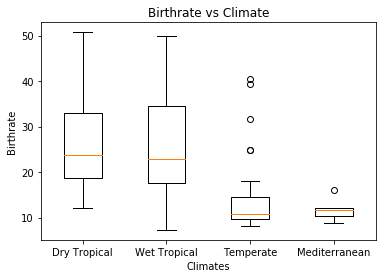

In [10]:
#plot data analysis
dryTropical = birthMortalityDF[(birthMortalityDF["Climate"] == 1)]['Birthrate']
wetTropical = birthMortalityDF[(birthMortalityDF["Climate"] == 2)]['Birthrate']
temperate = birthMortalityDF[(birthMortalityDF["Climate"] == 3)]['Birthrate']
mediterranean = birthMortalityDF[(birthMortalityDF["Climate"] == 4)]['Birthrate']

summaryClimate = [dryTropical, wetTropical, temperate, mediterranean]

fig1, ax1 = plt.subplots()
ax1.set_title('Birthrate vs Climate')
ax1.set_ylabel('Birthrate')
ax1.set_xlabel('Climates')
ax1.set_xticklabels(['Dry Tropical', 'Wet Tropical', 'Temperate', 'Mediterranean'])
ax1.boxplot(summaryClimate)

plt.show()

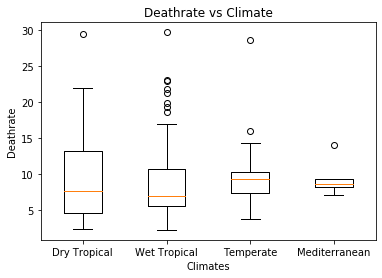

In [11]:
#plot data for analysis
dryTropical = birthMortalityDF[(birthMortalityDF["Climate"] == 1)]['Deathrate']
wetTropical = birthMortalityDF[(birthMortalityDF["Climate"] == 2)]['Deathrate']
temperate = birthMortalityDF[(birthMortalityDF["Climate"] == 3)]['Deathrate']
mediterranean = birthMortalityDF[(birthMortalityDF["Climate"] == 4)]['Deathrate']

summaryClimate = [dryTropical, wetTropical, temperate, mediterranean]

fig1, ax1 = plt.subplots()
ax1.set_title('Deathrate vs Climate')
ax1.set_ylabel('Deathrate')
ax1.set_xlabel('Climates')
ax1.set_xticklabels(['Dry Tropical', 'Wet Tropical', 'Temperate', 'Mediterranean'])
ax1.boxplot(summaryClimate)

plt.show()

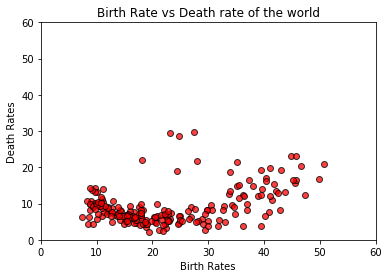

The correlation between both factors is 0.41


In [48]:
birthRatesDF = birthMortalityDF['Birthrate']
deathRatesDF = birthMortalityDF['Deathrate']

#Graph the data in a scatter plot
plt.scatter(birthRatesDF, deathRatesDF, marker="o", facecolors="red", edgecolors="black", alpha=0.75)
plt.xlabel('Birth Rates')
plt.ylabel('Death Rates')
plt.title('Birth Rate vs Death rate of the world')
plt.savefig('birthdeath', bbox_inches="tight")
plt.figsize=(200,200)

# format the x and y ticks
#plt.xticks([]),plt.yticks([])
plt.xlim(0,60)
plt.ylim(0,60)
plt.show()

correlation = st.pearsonr(birthRatesDF,deathRatesDF)
#print(correlation)

print(f"The correlation between both factors is {round(correlation[0],2)}")

#Preview the dataframe
df.head()

In [13]:
#Create a dataframe with just the data that you need to show the area of each region
area_df = rawCountriesDF[['Country','Region','Area (sq. mi.)']]
#area_df
area_df_grouped = area_df.groupby(['Region'])
#area_df_grouped.head()

In [14]:
#Consolidate the DF to region and area
area_totaled = area_df_grouped.sum()['Area (sq. mi.)']
#area_totaled
area_totaled_df = area_totaled.reset_index()
#area_totaled_df

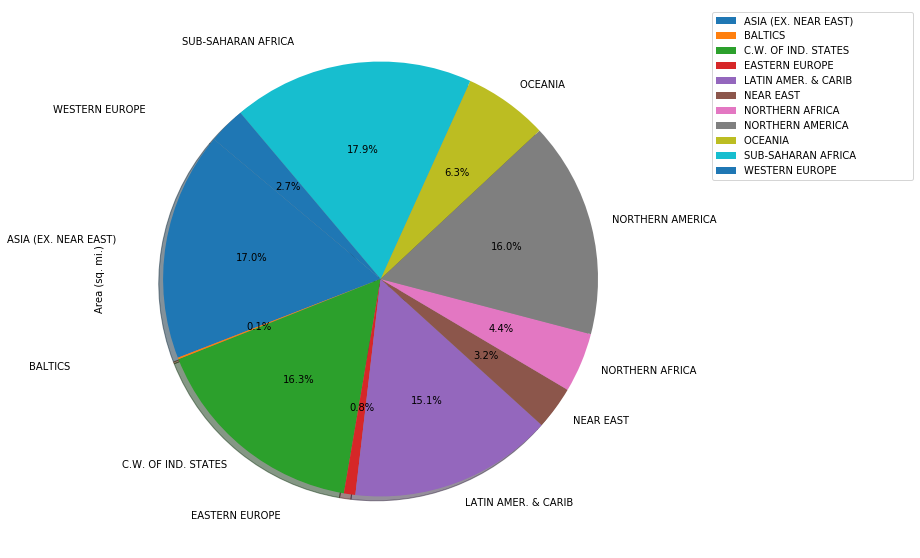

In [15]:
#Create a pie graph that displayed the data from the area dataframe
plot = area_totaled_df.plot.pie(y='Area (sq. mi.)', figsize=(10, 10), labels=area_totaled_df['Region'], 
                                autopct="%1.1f%%", shadow=True, startangle=140).legend(bbox_to_anchor=(1.1, 1))
plt.savefig('areapie', bbox_inches="tight")

In [16]:
#Create a dataframe from the original data that includes country, region, literacy %, phones per 1000, and population
new_df = rawCountriesDF[['Country','Region','Population', 'Literacy (%)', 'Phones (per 1000)']]
new_df.head()

#Convert commas to decimals for literacy % and phones per 1000
literacy_converted= new_df['Literacy (%)'].str.replace(',','.')
literacy =  literacy_converted.astype(float)
phones_converted=new_df['Phones (per 1000)'].str.replace(',','.')
phones =  phones_converted.astype(float)
country = new_df['Country']

In [17]:
#Create DF to show just the columns you will plot
phone_literacy_df = pd.DataFrame({'Country': country, 'Literacy': literacy, 'Phones': phones})
#phone_literacy_df

#Remove all rows that do not have value:
phone_literacy_filtered = phone_literacy_df.dropna()
#print(len(phone_literacy_filtered))
#phone_literacy_filtered

#Create DF for only rows that are numeric:
phone_literacy_numeric = phone_literacy_filtered[['Literacy', 'Phones']]
#print(phone_literacy_numeric)
#phone_literacy_numeric

In [18]:
#Create two separate list variables for the x and y axis - one for country vs literacy % and one for country vs phones per 1000
literacy = phone_literacy_numeric['Literacy']
phones = phone_literacy_numeric['Phones']
#print(literacy)
#print(phones)

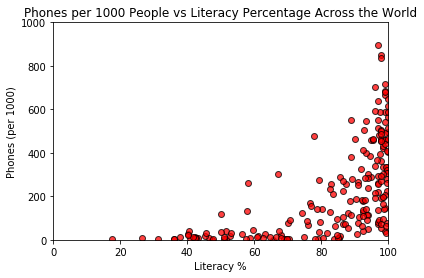

The correlation between both factors is 0.6


In [19]:
#Graph the data in a scatter plot
plt.scatter(literacy, phones, marker="o", facecolors="red", edgecolors="black", alpha=0.75)
plt.xlabel('Literacy %')
plt.ylabel('Phones (per 1000)')
plt.title('Phones per 1000 People vs Literacy Percentage Across the World')
plt.figsize=(200,200)

# format the x and y ticks
#plt.xticks([]),plt.yticks([])
plt.xlim(0,100)
plt.ylim(0,1000)
plt.show()

correlation = st.pearsonr(literacy,phones)
#print(correlation)

print(f"The correlation between both factors is {round(correlation[0],2)}")

y = 6.65x + -325.28


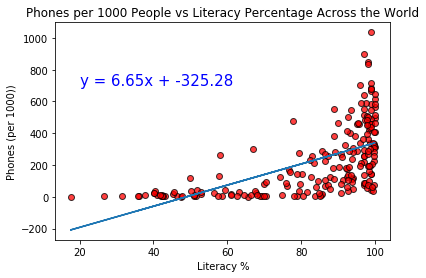

The correlation between both factors is 0.6


In [20]:
#Create a regression across the above scatter plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(literacy, phones)
regress_values = literacy * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(literacy, phones, marker="o", facecolors="red", edgecolors="black", alpha=0.75)
print(line_eq)
plt.plot(literacy,regress_values)
plt.annotate(line_eq,(20,700),fontsize=15,color="blue")
plt.ylabel('Phones (per 1000))')
plt.xlabel('Literacy %')
plt.title('Phones per 1000 People vs Literacy Percentage Across the World')
plt.savefig('phoneslit', bbox_inches="tight")
plt.figsize=(200,200)
plt.show()
print(f"The correlation between both factors is {round(correlation[0],2)}")

In [21]:
#Create dataframe with Country, Region, and Net Migration
df_data = rawCountriesDF[['Country', 'Region', 'Net migration']]
df_data.head()

,Country,Region,Net migration
0,Afghanistan,ASIA (EX. NEAR EAST),"23,06"
1,Albania,EASTERN EUROPE,"-4,93"
2,Algeria,NORTHERN AFRICA,"-0,39"
3,American Samoa,OCEANIA,"-20,71"
4,Andorra,WESTERN EUROPE,"6,6"


In [22]:
#Convert commas to decimals for net migration
migration_converted= df_data['Net migration'].str.replace(',','.')
migration =  migration_converted.astype(float)
country = df_data['Country']
region = df_data['Region']

In [23]:
#Convert values into new dataframe
migration_df = pd.DataFrame({'Country': country, 'Region': region, 'Net Migration': migration})
#migration_df

In [24]:
#Create a dataframe with just the data that you need
migration_grouped = migration_df.groupby(['Region']).mean()
migration_grouped_reset = migration_grouped.reset_index()
migration_grouped_reset.head()

,Region,Net Migration
0,ASIA (EX. NEAR EAST),1.372500
1,BALTICS,-2.033333
2,C.W. OF IND. STATES,-2.033333
3,EASTERN EUROPE,-0.647500
4,LATIN AMER. & CARIB,-1.494444


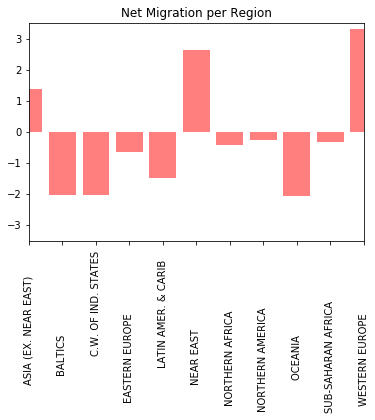

In [25]:
#Create the bar graph for Net Migration and Region
x=migration_grouped_reset["Region"]
y=migration_grouped_reset["Net Migration"]
# Shade the area between y1 and line y=0
plt.bar(x, y,
                 facecolor="red", # The fill color
                 color='blue',       # The outline color
                 alpha=0.5)          # Transparency of the fill
#Show the plot
#plt.ylim(0,y.max)
#plt.yticks(np.arange(0, 200))
#plt.xticks(rotation='horizontal')
plt.xticks(rotation='vertical')
#plt.yticks([])
plt.xlim(0,10)
plt.ylim(-3.5,3.5)
plt.title('Net Migration per Region')
plt.savefig('regionmigration', bbox_inches="tight")
plt.show()
#go through every row of the dataframe
#for row in data.itterrows():
#net migration / population density
#only plot top X

In [26]:
#Remove rows with data that does not exist
countryRowRemovedDF = rawCountriesDF.dropna()

In [27]:
#Remove commas from the numbers
countryRowRemovedDF["Infant mortality (per 1000 births)"] = countryRowRemovedDF["Infant mortality (per 1000 births)"].str.replace(',', ".")
countryRowRemovedDF["Pop. Density (per sq. mi.)"] = countryRowRemovedDF["Pop. Density (per sq. mi.)"].str.replace(',', ".")

/Users/juliedundas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/juliedundas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
#Set the x-values and convert the numbers to floats
x_values = countryRowRemovedDF["Infant mortality (per 1000 births)"].astype(float)
#x_values

In [29]:
#Set the y-values and convert the numbers to floats
y_values = countryRowRemovedDF["Pop. Density (per sq. mi.)"].astype(float)
#y_values

In [30]:
#Check for outliers
countryRowRemovedDF.sort_values(by=['Pop. Density (per sq. mi.)']).tail()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
77,Ghana,SUB-SAHARAN AFRICA,22409572,239460,93.6,"0,23","-0,64",51.43,2200.0,"74,8","14,4","16,26","9,67","74,07",2,"30,52","9,72","0,366","0,246","0,387"
168,Romania,EASTERN EUROPE,22303552,237500,93.9,"0,09","-0,13",26.43,7000.0,"98,4","196,9","40,82","2,25","56,93",3,"10,7","11,77","0,101","0,35","0,549"
12,Austria,WESTERN EUROPE,8192880,83870,97.7,"0,00",2,4.66,30000.0,"98,0","452,2","16,91","0,86","82,23",3,"8,74","9,76","0,018","0,304","0,678"
202,Togo,SUB-SAHARAN AFRICA,5548702,56785,97.7,"0,10",0,66.61,1500.0,"60,9","10,6","46,15","2,21","51,64",2,"37,01","9,83","0,395","0,204","0,401"
9,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,"0,00","-6,47",23.28,3500.0,"98,6","195,7","17,55","2,3","80,15",4,"12,07","8,23","0,239","0,343","0,418"


In [31]:
#Determine linear model for data
x_values = countryRowRemovedDF["Infant mortality (per 1000 births)"].astype(float)
y_values = countryRowRemovedDF["Pop. Density (per sq. mi.)"].astype(float)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

y = -5.59x + 512.16


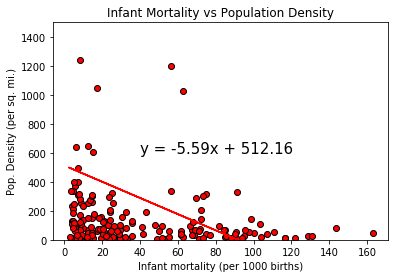

In [32]:
#Graph the data with the linear model included
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values, y_values, marker="o", facecolors="red", edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.plot(figsize=(100,500))
plt.ylim(0,1500)
plt.annotate(line_eq,(40,600),fontsize=15,color="black")
plt.xlabel("Infant mortality (per 1000 births)")
plt.ylabel("Pop. Density (per sq. mi.)")
plt.title("Infant Mortality vs Population Density")
plt.savefig('infantmortcountry', bbox_inches="tight")
plt.show()

In [33]:
correlation = st.pearsonr(x_values, y_values)
correlation
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is -0.14


In [34]:
# If the data is in a dataframe, we use pandas to give quartile calculations
quartiles = x_values.quantile([.25,.5,.75])
lowerq = quartiles[0.25].round(2)
upperq = quartiles[0.75].round(2)
iqr = (upperq-lowerq).round(2)

print(f"The lower quartile of Infant mortality is: {lowerq}")
print(f"The upper quartile of Population density is: {upperq}")
print(f"The interquartile range of Population density is: {iqr}")
print(f"The the median of Population density is: {quartiles[0.5]} ")

lower_bound = (lowerq - (1.5*iqr)).round(2)
upper_bound = (upperq + (1.5*iqr)).round(2)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of Infant mortality is: 9.99
The upper quartile of Population density is: 64.6
The interquartile range of Population density is: 54.61
The the median of Population density is: 24.31 
Values below -71.92 could be outliers.
Values above 146.51 could be outliers.


In [35]:
# If the data is in a dataframe, we use pandas to give quartile calculations
quartiles = y_values.quantile([.25,.5,.75])
lowerq = quartiles[0.25].round(2)
upperq = quartiles[0.75].round(2)
iqr = (upperq-lowerq).round(2)

print(f"The lower quartile of Infant mortality is: {lowerq}")
print(f"The upper quartile of Infant mortality is: {upperq}")
print(f"The interquartile range of Infant mortality is: {iqr}")
print(f"The the median of Infant mortality is: {quartiles[0.5]} ")

lower_bound = (lowerq - (1.5*iqr)).round(2)
upper_bound = (upperq + (1.5*iqr)).round(2)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of Infant mortality is: 26.8
The upper quartile of Infant mortality is: 164.7
The interquartile range of Infant mortality is: 137.9
The the median of Infant mortality is: 66.9 
Values below -180.05 could be outliers.
Values above 371.55 could be outliers.


In [36]:
#Create variables for the next data frame
infant = countryRowRemovedDF["Infant mortality (per 1000 births)"].astype(float)
pop = countryRowRemovedDF["Pop. Density (per sq. mi.)"].astype(float)
country = countryRowRemovedDF["Country"]
region = countryRowRemovedDF["Region"]

In [37]:
#Create the dataframe 
combined_df = pd.DataFrame({"Country": country, "Region": region, "Infant mortality (per 1000 births)": infant, "Pop. Density (per sq. mi.)": pop})

In [38]:
#Show the new data frame
combined_df

,Country,Region,Infant mortality (per 1000 births),Pop. Density (per sq. mi.)
0,Afghanistan,ASIA (EX. NEAR EAST),163.07,48.0
1,Albania,EASTERN EUROPE,21.52,124.6
2,Algeria,NORTHERN AFRICA,31.00,13.8
6,Anguilla,LATIN AMER. & CARIB,21.03,132.1
7,Antigua & Barbuda,LATIN AMER. & CARIB,19.46,156.0
...,...,...,...,...
218,Venezuela,LATIN AMER. & CARIB,22.20,28.2
219,Vietnam,ASIA (EX. NEAR EAST),25.95,256.1
224,Yemen,NEAR EAST,61.50,40.6
225,Zambia,SUB-SAHARAN AFRICA,88.29,15.3


In [39]:
#Use groupby to group the data frame by region
new_df_grouped = combined_df.groupby(["Region"]).sum()
new_df_grouped.head()

,Infant mortality (per 1000 births),Pop. Density (per sq. mi.)
Region,,
ASIA (EX. NEAR EAST),1055.45,35152.1
BALTICS,17.42,64.5
C.W. OF IND. STATES,477.11,540.1
EASTERN EUROPE,89.51,645.5
LATIN AMER. & CARIB,873.12,5930.5


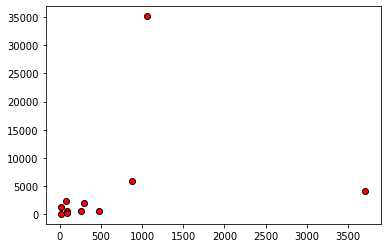

In [40]:
#Plot the dataframe in a scatter plot
plt.scatter(new_df_grouped["Infant mortality (per 1000 births)"], new_df_grouped["Pop. Density (per sq. mi.)"], marker="o", facecolors="red", edgecolors="black")
plt.show()

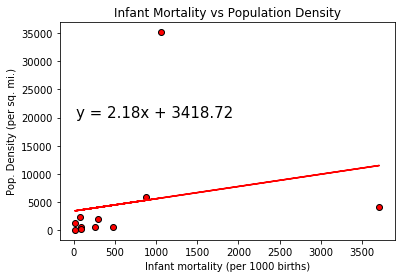

In [41]:
#Plot the dataframe with the regression line
(slope, intercept, rvalue, pvalue, stderr) = linregress(new_df_grouped["Infant mortality (per 1000 births)"], new_df_grouped["Pop. Density (per sq. mi.)"])
regress_values = new_df_grouped["Infant mortality (per 1000 births)"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(new_df_grouped["Infant mortality (per 1000 births)"], new_df_grouped["Pop. Density (per sq. mi.)"], marker="o", facecolors="red", edgecolors="black")
plt.plot(new_df_grouped["Infant mortality (per 1000 births)"],regress_values,"r-")
plt.annotate(line_eq,(30,20000),fontsize=15,color="black")
plt.xlabel("Infant mortality (per 1000 births)")
plt.ylabel("Pop. Density (per sq. mi.)")
plt.title("Infant Mortality vs Population Density")
plt.savefig('infantmortregion', bbox_inches="tight")
plt.show()

In [42]:
correlation = st.pearsonr(new_df_grouped["Infant mortality (per 1000 births)"], new_df_grouped["Pop. Density (per sq. mi.)"])
correlation
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.23


In [43]:
# If the data is in a dataframe, we use pandas to give quartile calculations
quartiles = new_df_grouped["Pop. Density (per sq. mi.)"].quantile([.25,.5,.75])
lowerq = quartiles[0.25].round(2)
upperq = quartiles[0.75].round(2)
iqr = (upperq-lowerq).round(2)

print(f"The lower quartile of Population density is: {lowerq}")
print(f"The upper quartile of Population density is: {upperq}")
print(f"The interquartile range of Population density is: {iqr}")
print(f"The the median of Population density is: {quartiles[0.5]} ")

lower_bound = (lowerq - (1.5*iqr)).round(2)
upper_bound = (upperq + (1.5*iqr)).round(2)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of Population density is: 565.8
The upper quartile of Population density is: 3215.9
The interquartile range of Population density is: 2650.1
The the median of Population density is: 1272.0 
Values below -3409.35 could be outliers.
Values above 7191.05 could be outliers.


In [44]:
# If the data is in a dataframe, we use pandas to give quartile calculations
quartiles = new_df_grouped["Infant mortality (per 1000 births)"].quantile([.25,.5,.75])
lowerq = quartiles[0.25].round(2)
upperq = quartiles[0.75].round(2)
iqr = (upperq-lowerq).round(2)

print(f"The lower quartile of Infant mortality is: {lowerq}")
print(f"The upper quartile of Infant mortality is: {upperq}")
print(f"The interquartile range of Infant mortality is: {iqr}")
print(f"The the median of Infant mortality is: {quartiles[0.5]} ")

lower_bound = (lowerq - (1.5*iqr)).round(2)
upper_bound = (upperq + (1.5*iqr)).round(2)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of Infant mortality is: 81.85
The upper quartile of Infant mortality is: 675.12
The interquartile range of Infant mortality is: 593.27
The the median of Infant mortality is: 260.76 
Values below -808.06 could be outliers.
Values above 1565.02 could be outliers.


In [46]:

###Summarize your findings
print('What is the relationship between death/birth rates and the climates? The data does suggest there are some factors that climate plays. In temperate and mediterranean regions, the spread is tighter with lower death and birth rates compared to other areas like tropics and desert. Conicidently this also tends to be where more first world countries are and may have more to do with economic factors though climate has a part of that as well.')
print('')
print("How much area does each region/ continent take up? Based on our analysis, we can see that the largest region of the world is Sub-Saharan Africa, which takes up 17.9% of the entire world's land mass. Conversely, the smallest land area is Eastern Europe, which only takes up 0.8% of the world's land mass.")
print('')
print("What is the relationship between phone ownership and literacy per region? Based on our analysis, the correlation between phone usage and literacy is 0.60. Since this is stronger than 0.40, we can consider this to be a relatively strong, positive correlation. There is relatively strong correlation that the higher the literacy percentage, the greater the phone ownership throughout the world")
print('')
print("Net migration rates show that there are regions where there are more people entering than leaving an area. The negative migration rate means that more people are leaving than entering a region. When the graph shows a number closer to zero that means that there is a balance in the net migration  equal number of immigrants and emigrants. in this graph we can see what migration is per region.")
print('')
print("Is there correlation between infant mortality rates and population density per country? The correlation between infant mortality and population density for each country is -.14. This indicates there is no correlation between infant mortality and population density.") 
print('')
print("Is there correlation between infant mortality rates and population density per region? The data for infant mortality and population density grouped by region is .23 which also indicates there is a weak, positive correlation between infant mortality and population density.")

What is the relationship between death/birth rates and the climates? The data does suggest there are some factors that climate plays. In temperate and mediterranean regions, the spread is tighter with lower death and birth rates compared to other areas like tropics and desert. Conicidently this also tends to be where more first world countries are and may have more to do with economic factors though climate has a part of that as well.

How much area does each region/ continent take up? Based on our analysis, we can see that the largest region of the world is Sub-Saharan Africa, which takes up 17.9% of the entire world's land mass. Conversely, the smallest land area is Eastern Europe, which only takes up 0.8% of the world's land mass.

What is the relationship between phone ownership and literacy per region? Based on our analysis, the correlation between phone usage and literacy is 0.60. Since this is stronger than 0.40, we can consider this to be a relatively strong, positive correlati